# Model Comparison: LSTM vs Bi-LSTM for Personal Health Mentions Classification



In [80]:
# Import all the libraries needed
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt    # for visualization
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import re

In [182]:
import random
import numpy as np
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [81]:
# Load the health tweets datasets
import pathlib
from google.colab import drive
drive.mount('/content/drive')
data_dir1 = pathlib.Path('/content/drive/My Drive/health tweets/phm_train.csv')
data_dir2 = pathlib.Path('/content/drive/My Drive/health tweets/phm_test.csv')
train_df = pd.read_csv(data_dir1)
test_df = pd.read_csv(data_dir2)



print("Training Data:")
print(train_df.head())
print(f"\nTraining data shape: {train_df.shape}")
print("\nTest Data:")
print(test_df.head())
print(f"\nTest data shape: {test_df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Data:
       tweet_id  label                                              tweet
0  6.430000e+17      0  user_mention all i can tell you is i have had ...
1  6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2  8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3  6.820000e+17      0  i got xans in an advil bottle i dont take them...
4  6.440000e+17      1  mom says i need to stop eating so much bc ive ...

Training data shape: (9991, 3)

Test Data:
       tweet_id  label                                              tweet
0  6.411550e+17      0  when you try to run away from the iv needle so...
1  6.425520e+17      1  i just knew i took an ambien for sleep too ear...
2  6.410410e+17      1  i mean i get that my celexa is the reason behi...
3  7.476620e+17      0  if you call me dumb or her dumb one more time ..

In [82]:
# Declare stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
def load_dataset():
    # Use separate training and test data (not train_test_split)
    x_train = train_df['tweet']       # Tweets/Input from training data
    y_train = train_df['label']       # Labels/Output from training data
    x_test = test_df['tweet']         # Tweets/Input from test data
    y_test = test_df['label']         # Labels/Output from test data

    # PRE-PROCESS TWEETS (Training data)
    x_train = x_train.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_train = x_train.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_train = x_train.apply(lambda tweet: [w for w in tweet.split() if w not in english_stops])  # remove stop words
    x_train = x_train.apply(lambda tweet: [w.lower() for w in tweet])   # lower case

    # PRE-PROCESS TWEETS (Test data)
    x_test = x_test.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_test = x_test.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_test = x_test.apply(lambda tweet: [w for w in tweet.split() if w not in english_stops])  # remove stop words
    x_test = x_test.apply(lambda tweet: [w.lower() for w in tweet])   # lower case

    # Labels are already encoded as 0 & 1 in the dataset
    # 1 = personal health mentions, 0 = non-personal health mentions

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_dataset()

In [84]:
def get_max_length():
    tweet_length = []
    for tweet in x_train:
        tweet_length.append(len(tweet))

    return int(np.ceil(np.mean(tweet_length)))

In [85]:
# ENCODE TWEETS
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_dataset()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Maximum tweet length: ', max_length)

Maximum tweet length:  10


## LSTM Model

In [202]:
# LSTM Architecture
EMBED_DIM = 100
LSTM_OUT = 128

lstm_model = Sequential()
lstm_model.add(Embedding(total_words, EMBED_DIM))
lstm_model.add(LSTM(LSTM_OUT))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.add(Dropout(0.5))
lstm_model.build(input_shape=(None, max_length))
lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print(lstm_model.summary())

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 10, 100)        │     1,266,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,383,377 (5.28 MB)

 Trainable params: 1,383,377 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [203]:
lstm_checkpoint = ModelCheckpoint(
    'models/LSTM_health_comparison.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [204]:
class_weights = {0: 1.0, 1: 2.5}
lstm_history = lstm_model.fit(x_train, y_train, class_weight= class_weights, batch_size = 128, epochs = 10, callbacks=[lstm_checkpoint], validation_split=0.1)

Epoch 1/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5202 - loss: 7.0662
Epoch 1: accuracy improved from -inf to 0.57191, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.5216 - loss: 7.0512 - val_accuracy: 0.7470 - val_loss: 0.5352
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6833 - loss: 6.5557
Epoch 2: accuracy improved from 0.57191 to 0.70548, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.6836 - loss: 6.5539 - val_accuracy: 0.7640 - val_loss: 0.4431
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7580 - loss: 6.5722
Epoch 3: accuracy improved from 0.70548 to 0.76165, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7581 - loss: 6.5699 - val_accuracy: 0.7810 - val_loss: 0.4388
Epoch 4/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7698 - loss: 6.3297
Epoch 4: accuracy improved from 0.76165 to 0.77522, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7699 - loss: 6.3261 - val_accuracy: 0.7480 - val_loss: 0.4424
Epoch 5/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7792 - loss: 6.3742
Epoch 5: accuracy improved from 0.77522 to 0.78111, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7793 - loss: 6.3710 - val_accuracy: 0.7560 - val_loss: 0.4392
Epoch 6/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7888 - loss: 6.3554
Epoch 6: accuracy improved from 0.78111 to 0.79791, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7890 - loss: 6.3482 - val_accuracy: 0.7740 - val_loss: 0.4330
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8031 - loss: 6.1932
Epoch 7: accuracy improved from 0.79791 to 0.80369, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8031 - loss: 6.1918 - val_accuracy: 0.7590 - val_loss: 0.4559
Epoch 8/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8100 - loss: 6.0183
Epoch 8: accuracy improved from 0.80369 to 0.80825, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8100 - loss: 6.0228 - val_accuracy: 0.8030 - val_loss: 0.4480
Epoch 9/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8089 - loss: 6.2078
Epoch 9: accuracy improved from 0.80825 to 0.81203, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8090 - loss: 6.2058 - val_accuracy: 0.7800 - val_loss: 0.4446
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8149 - loss: 6.1271
Epoch 10: accuracy improved from 0.81203 to 0.81715, saving model to models/LSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8150 - loss: 6.1259 - val_accuracy: 0.8000 - val_loss: 0.4698


## Bidirectional LSTM Model

In [205]:
# Bi-LSTM Architecture
EMBED_DIM = 100
LSTM_OUT = 128

bilstm_model = Sequential()
bilstm_model.add(Embedding(total_words, EMBED_DIM))
bilstm_model.add(Bidirectional(LSTM(LSTM_OUT)))
bilstm_model.add(Dense(1, activation='sigmoid'))
bilstm_model.add(Dropout(0.5))
bilstm_model.build(input_shape=(None, max_length))
bilstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print(bilstm_model.summary())

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 10, 100)        │     1,266,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 256)            │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,753 (5.72 MB)

 Trainable params: 1,500,753 (5.72 MB)

 Non-trainable params: 0 (0.00 B)

None


In [206]:
bilstm_checkpoint = ModelCheckpoint(
    'models/BiLSTM_health_comparison.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [207]:
class_weights = {0: 1.0, 1: 2.5}
bilstm_history = bilstm_model.fit(x_train, y_train, class_weight= class_weights,  batch_size = 128, epochs = 10, callbacks=[bilstm_checkpoint], validation_split=0.1)

Epoch 1/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5462 - loss: 6.7808
Epoch 1: accuracy improved from -inf to 0.60772, saving model to models/BiLSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.5479 - loss: 6.7725 - val_accuracy: 0.7470 - val_loss: 0.5057
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7428 - loss: 6.0379
Epoch 2: accuracy improved from 0.60772 to 0.75509, saving model to models/BiLSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7430 - loss: 6.0380 - val_accuracy: 0.7470 - val_loss: 0.5018
Epoch 3/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7654 - loss: 6.1437
Epoch 3: accuracy improved from 0.75509 to 0.77177, saving model to models/BiLSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.7656 - loss: 6.1456 - val_accuracy: 0.7540 - val_loss: 0.4472
Epoch 4/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7867 - loss: 5.9761
Epoch 4: accuracy improved from 0.77177 to 0.78745, saving model to models/BiLSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.7868 - loss: 5.9778 - val_accuracy: 0.7760 - val_loss: 0.4464
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7871 - loss: 6.3095
Epoch 5: accuracy improved from 0.78745 to 0.79424, saving model to models/BiLSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.7872 - loss: 6.3089 - val_accuracy: 0.7470 - val_loss: 0.5282
Epoch 6/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7931 - loss: 6.3892
Epoch 6: accuracy improved from 0.79424 to 0.79824, saving model to models/BiLSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.7933 - loss: 6.3847 - val_accuracy: 0.7620 - val_loss: 0.4737
Epoch 7/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8041 - loss: 6.4442
Epoch 7: accuracy improved from 0.79824 to 0.80992, saving model to models/BiLSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.8043 - loss: 6.4401 - val_accuracy: 0.8060 - val_loss: 0.4493
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7910 - loss: 6.2196
Epoch 8: accuracy did not improve from 0.80992
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.7910 - loss: 6.2186 - val_accuracy: 0.7580 - val_loss: 0.4609
Epoch 9/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8203 - loss: 5.9969
Epoch 9: accuracy improved from 0.80992 to 0.81793, saving model to models/BiLSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8203 - loss: 6.0004 - val_accuracy: 0.7900 - val_loss: 0.4786
Epoch 10/10
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8161 - loss: 6.1662
Epoch 10: accuracy improved from 0.81793 to 0.82049, saving model to models/BiLSTM_health_comparison.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8162 - loss: 6.1650 - val_accuracy: 0.7960 - val_loss: 0.4762


## Model Comparison and Evaluation

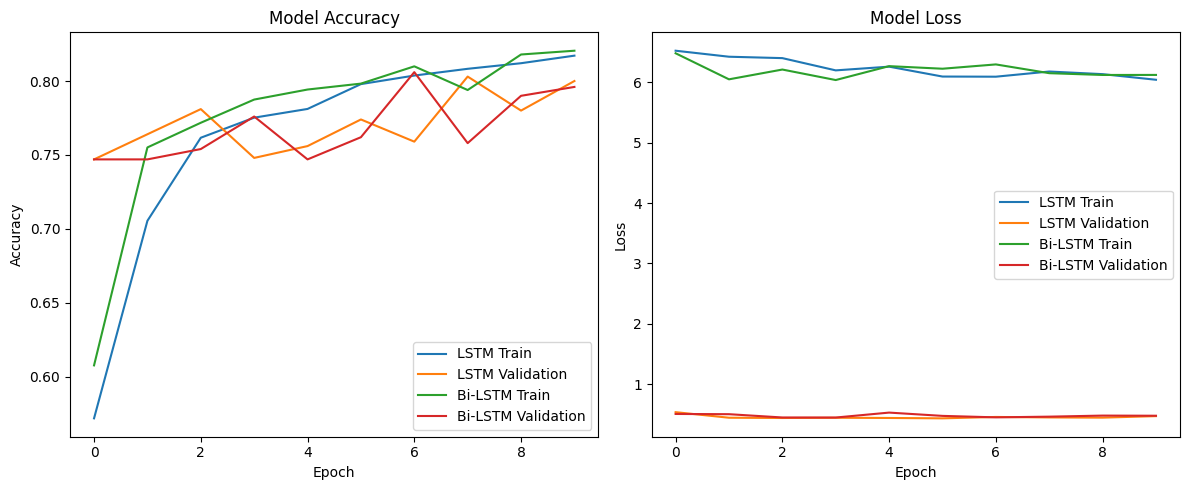

In [208]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation')
plt.plot(bilstm_history.history['accuracy'], label='Bi-LSTM Train')
plt.plot(bilstm_history.history['val_accuracy'], label='Bi-LSTM Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation')
plt.plot(bilstm_history.history['loss'], label='Bi-LSTM Train')
plt.plot(bilstm_history.history['val_loss'], label='Bi-LSTM Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('model_comparison_training.png')
plt.show()

In [209]:
# Evaluate models on test set
# LSTM Evaluation
lstm_pred = lstm_model.predict(x=x_test)
lstm_pred_binary = (lstm_pred >= 0.5) * 1

lstm_true = 0
for i, y in enumerate(y_test):
    if y == lstm_pred_binary[i]:
        lstm_true += 1

print('=== LSTM Model Performance ===')
print('Correct Prediction: {}'.format(lstm_true))
print('Wrong Prediction: {}'.format(len(lstm_pred_binary) - lstm_true))
print('Accuracy: {:.4f}%'.format(lstm_true/len(lstm_pred_binary)*100))

# Bi-LSTM Evaluation
bilstm_pred = bilstm_model.predict(x=x_test)
bilstm_pred_binary = (bilstm_pred >= 0.5) * 1

bilstm_true = 0
for i, y in enumerate(y_test):
    if y == bilstm_pred_binary[i]:
        bilstm_true += 1

print('\n=== Bidirectional LSTM Model Performance ===')
print('Correct Prediction: {}'.format(bilstm_true))
print('Wrong Prediction: {}'.format(len(bilstm_pred_binary) - bilstm_true))
print('Accuracy: {:.4f}%'.format(bilstm_true/len(bilstm_pred_binary)*100))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
=== LSTM Model Performance ===
Correct Prediction: 2602
Wrong Prediction: 729
Accuracy: 78.1147%
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step

=== Bidirectional LSTM Model Performance ===
Correct Prediction: 2624
Wrong Prediction: 707
Accuracy: 78.7751%


In [210]:
# Generate classification reports
print("LSTM Classification Report:")
print(classification_report(y_test, lstm_pred_binary, target_names=['Non-Personal Health', 'Personal Health']))

print("\nBi-LSTM Classification Report:")
print(classification_report(y_test, bilstm_pred_binary, target_names=['Non-Personal Health', 'Personal Health']))

LSTM Classification Report:
                     precision    recall  f1-score   support

Non-Personal Health       0.78      0.97      0.86      2364
    Personal Health       0.83      0.31      0.45       967

           accuracy                           0.78      3331
          macro avg       0.80      0.64      0.66      3331
       weighted avg       0.79      0.78      0.74      3331


Bi-LSTM Classification Report:
                     precision    recall  f1-score   support

Non-Personal Health       0.79      0.96      0.87      2364
    Personal Health       0.81      0.35      0.49       967

           accuracy                           0.79      3331
          macro avg       0.80      0.66      0.68      3331
       weighted avg       0.79      0.79      0.76      3331



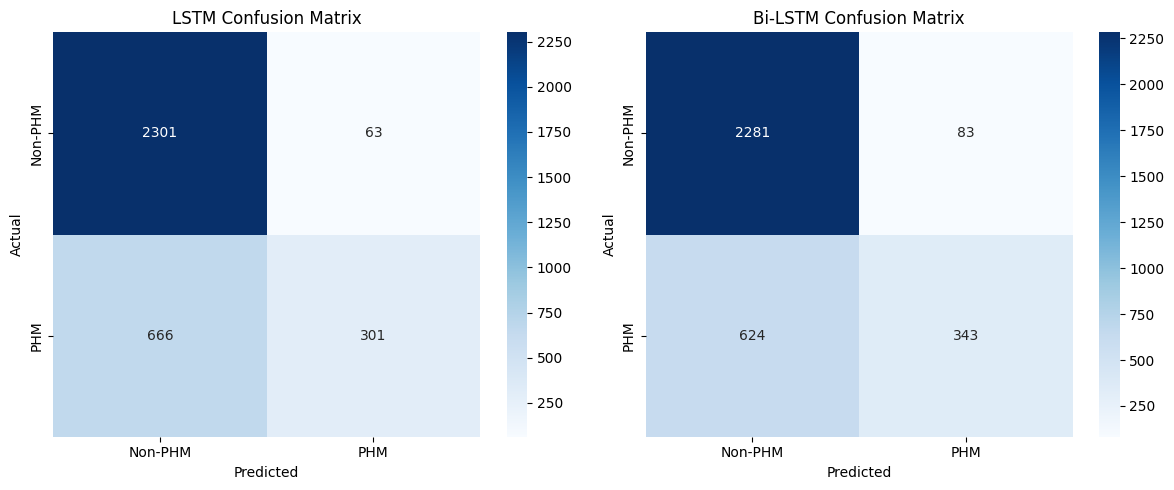

In [211]:
# Plot confusion matrices
plt.figure(figsize=(12, 5))

# LSTM Confusion Matrix
plt.subplot(1, 2, 1)
lstm_cm = confusion_matrix(y_test, lstm_pred_binary)
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-PHM', 'PHM'], yticklabels=['Non-PHM', 'PHM'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Bi-LSTM Confusion Matrix
plt.subplot(1, 2, 2)
bilstm_cm = confusion_matrix(y_test, bilstm_pred_binary)
sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-PHM', 'PHM'], yticklabels=['Non-PHM', 'PHM'])
plt.title('Bi-LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

In [212]:
# Performance difference
accuracy_diff = (bilstm_true/len(bilstm_pred_binary)*100) - (lstm_true/len(lstm_pred_binary)*100)

print('=== Performance Analysis ===')
if accuracy_diff > 0:
    print(f'Bi-LSTM achieves {accuracy_diff:.2f}% higher accuracy than LSTM')
elif accuracy_diff < 0:
    print(f'LSTM achieves {abs(accuracy_diff):.2f}% higher accuracy than Bi-LSTM')
else:
    print('Both models achieve the same accuracy')

=== Performance Analysis ===
Bi-LSTM achieves 0.66% higher accuracy than LSTM
